# Equi Boots Graphical Notebook

## Library Imports

In [1]:
import pandas as pd
import numpy as np
import os
import sys

# Add path to import EquiBoots
script_path = os.path.abspath("../py_scripts")
print("Appending path:", script_path)
sys.path.append(script_path)

Appending path: /home/lshpaner/Documents/GitHub_Repositories/equi_boots/py_scripts


In [2]:
import equiboots as eqb

## Prepping equiboots

### Classification Mock-Up

In [3]:
# Generate synthetic test data
y_prob = np.random.rand(1000)
y_pred = y_prob > 0.5
y_true = np.random.randint(0, 2, 1000)

race = (
    np.random.RandomState(3)
    .choice(["white", "black", "asian", "hispanic"], 1000)
    .reshape(-1, 1)
)
sex = np.random.choice(["M", "F"], 1000).reshape(-1, 1)

fairness_df = pd.DataFrame(
    data=np.concatenate((race, sex), axis=1), columns=["race", "sex"]
)

# Initialize and process groups
eq = eqb.EquiBoots(
    y_true=y_true,
    y_prob=y_prob,
    y_pred=y_pred,
    fairness_df=fairness_df,
    fairness_vars=["race", "sex"],
)
eq.grouper(groupings_vars=["race", "sex"])
sliced_data = eq.slicer("race")

Groups created


### Regression Mock-Up

In [4]:
## Generate synthetic regression-like data
np.random.seed(42)
y_true_reg = np.random.normal(loc=50, scale=10, size=1000)  ## continuous target
y_pred_reg = y_true_reg + np.random.normal(
    loc=0, scale=5, size=1000
)  # predicted value with noise

# Not really 'prob', but using this slot for predicted values
y_prob_reg = y_pred_reg

## Regression Residuals

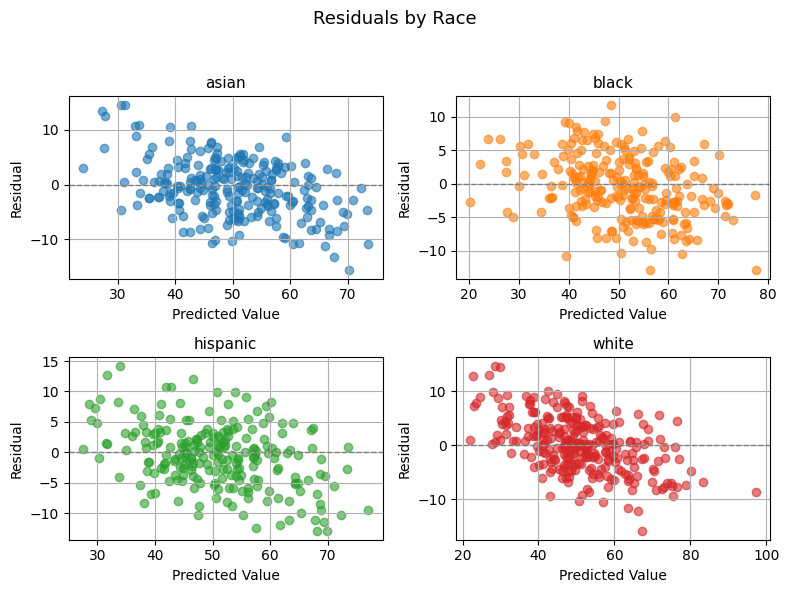

In [15]:
eqb.eq_plot_residuals_by_group(
    y_true=y_true_reg,
    y_prob=y_prob_reg,
    group=fairness_df["race"],
    title="Residuals by Race",
    filename="residuals_by_race",
    subplots=True,
    color_by_group=True,
    # n_cols=1,
    # n_rows=2,
    figsize=(8, 6),
    # show_centroids=True,
    save_path="./images",
)

## ROC AUC by Group (ex. Race)

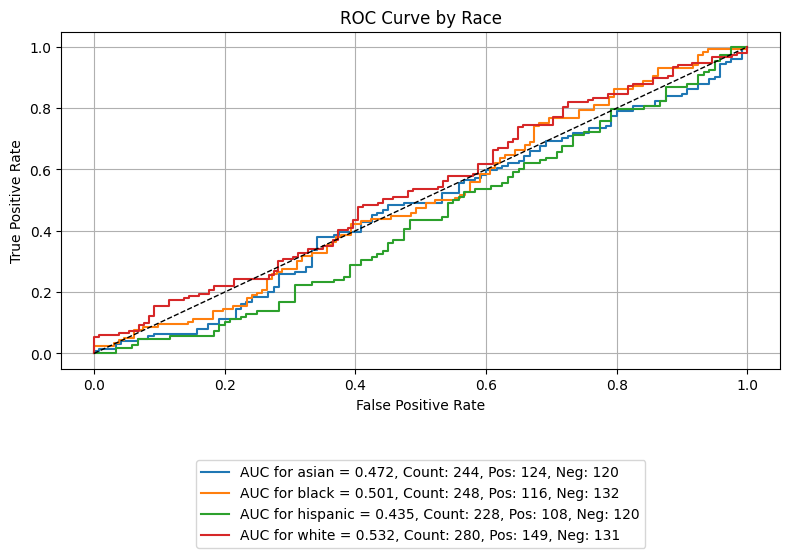

In [6]:
eqb.eq_plot_roc_auc(
    data=sliced_data,
    title="ROC Curve by Race",
    decimal_places=3,
    save_path="./images",
)

## Precision-Recall Curves

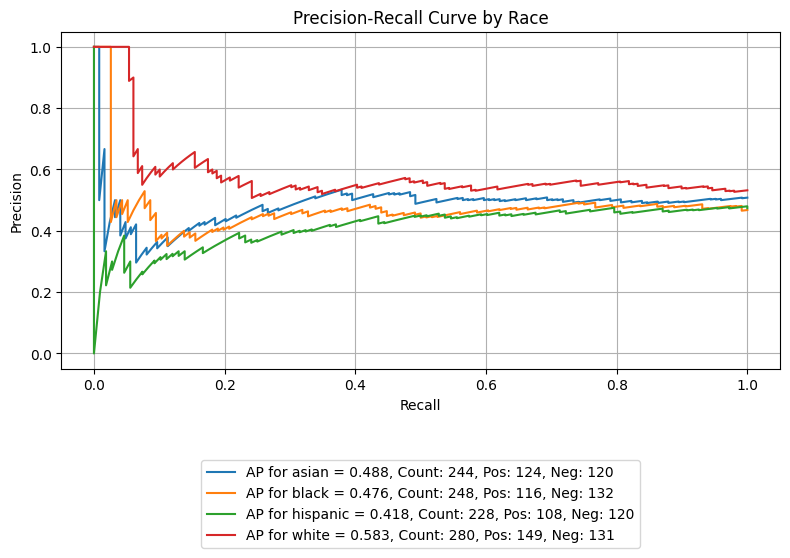

In [7]:
# Precision-Recall plot
fig2 = eqb.eq_plot_precision_recall(
    data=sliced_data,
    title="Precision-Recall Curve by Race",
    # tick_fontsize=8,
    decimal_places=3,
    dpi=100,
    save_path="./images",
)

## Calibration Plot

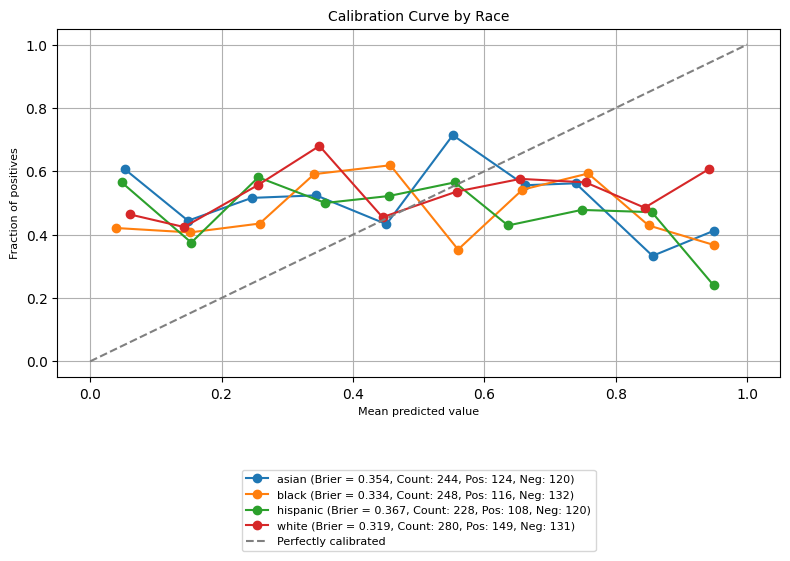

In [8]:
# Calibration plot
fig3 = eqb.eq_calibration_curve_plot(
    data=sliced_data,
    n_bins=10,
    title="Calibration Curve by Race",
    tick_fontsize=8,
    decimal_places=3,
    save_path="./images",
)
fig3

## Bootstrap Graphs

In [9]:
eq2 = eqb.EquiBoots(
    y_true,
    y_prob,
    y_pred,
    fairness_df,
    fairness_vars=["race", "sex"],
    reference_groups=["white", "M"],
    task="binary_classification",
    bootstrap_flag=True,
    num_bootstraps=10,
    boot_sample_size=100,
    balanced=False,  # False is stratified, True is balanced
    # stratify_by_outcome=True,
)

# Set seeds
int_list = np.linspace(0, 100, num=10, dtype=int).tolist()

eq2.set_fix_seeds(int_list)

print("seeds", eq2.seeds)

eq2.grouper(groupings_vars=["race", "sex"])
sliced_data = eq.slicer("race")

data = eq2.slicer("race")
race_metrics = eq2.get_metrics(data)

dispa = eq2.calculate_disparities(race_metrics, "race")

melted = pd.DataFrame(dispa).melt()
df = melted["value"].apply(pd.Series).assign(attribute_value=melted["variable"])

seeds [0, 11, 22, 33, 44, 55, 66, 77, 88, 100]


Bootstrapping iterations: 100%|██████████| 10/10 [00:00<00:00, 569.24it/s]

Groups created


### Disparity plots

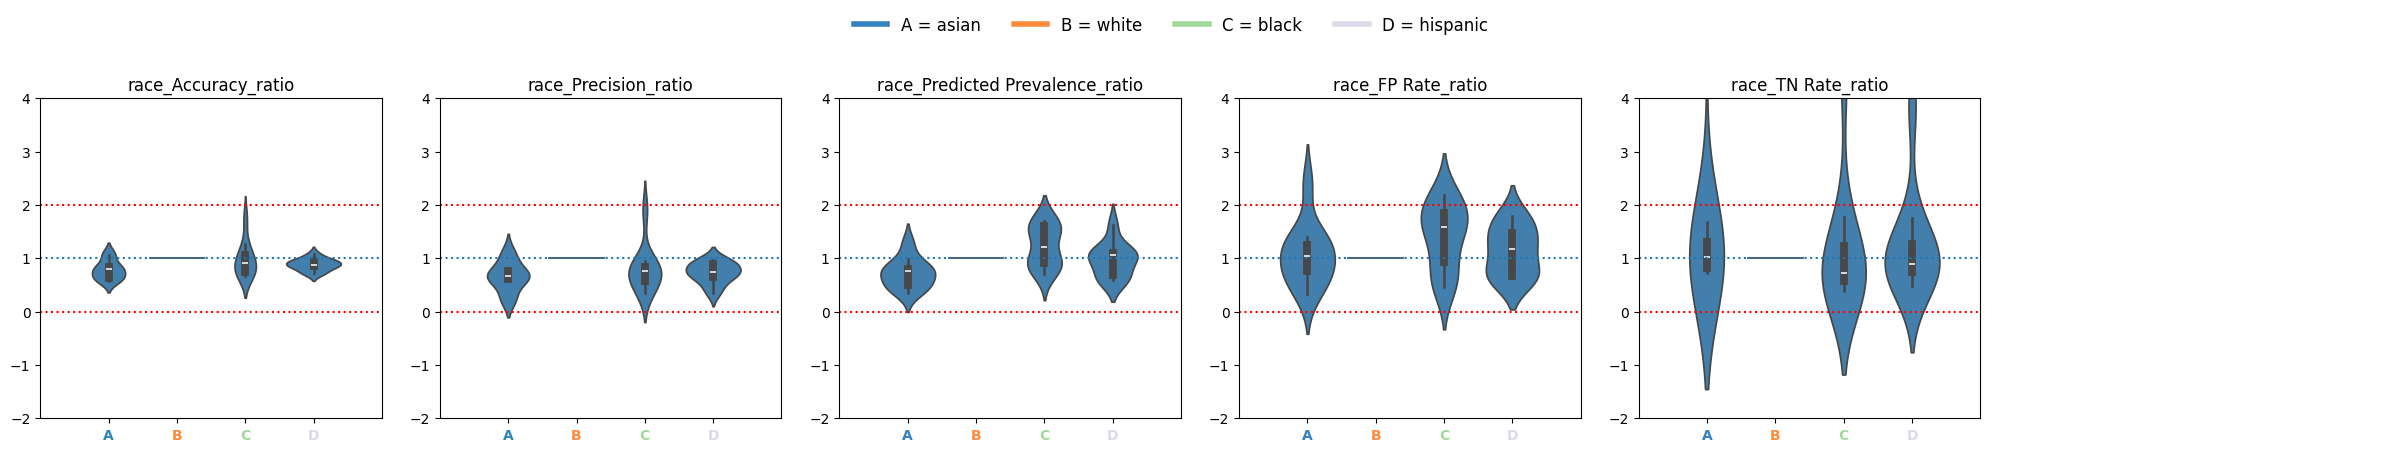

In [10]:
eqb.eq_disparity_metrics_plot(
    dispa,
    metric_cols=[
        "Accuracy_ratio",
        "Precision_ratio",
        "Predicted Prevalence_ratio",
        "FP Rate_ratio",
        "TN Rate_ratio",
    ],
    name="race",
    categories="all",
    figsize=(24, 4),
    plot_kind="violinplot",
    save_path="./images",
)

### ROCAUC Bootstrap

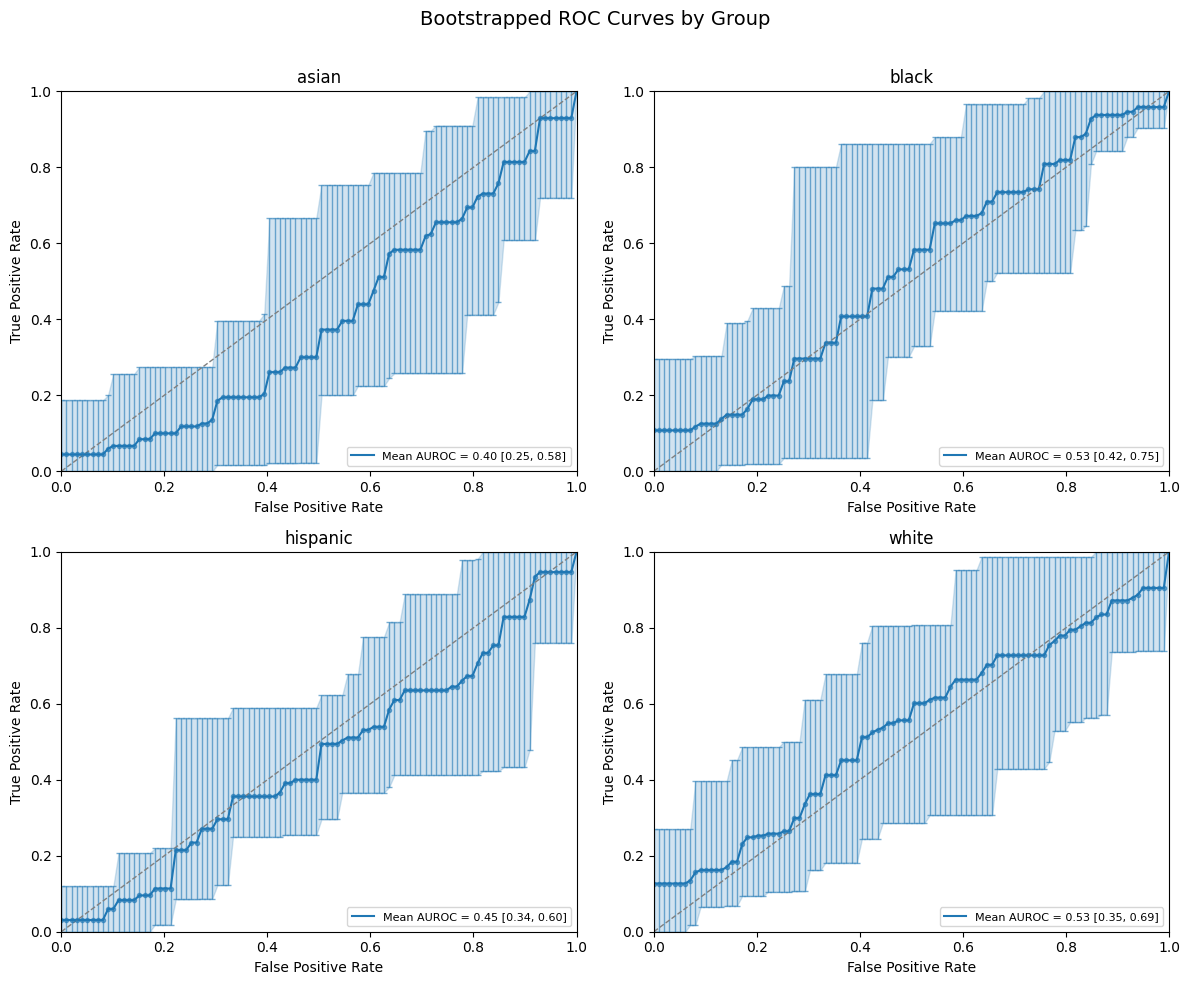

In [11]:
from equiboots import eq_plot_bootstrapped_roc_curves

sliced = eq2.slicer(slicing_var="race")
eq_plot_bootstrapped_roc_curves(
    sliced,
    bar_every=100,
    save_path="./images",
)

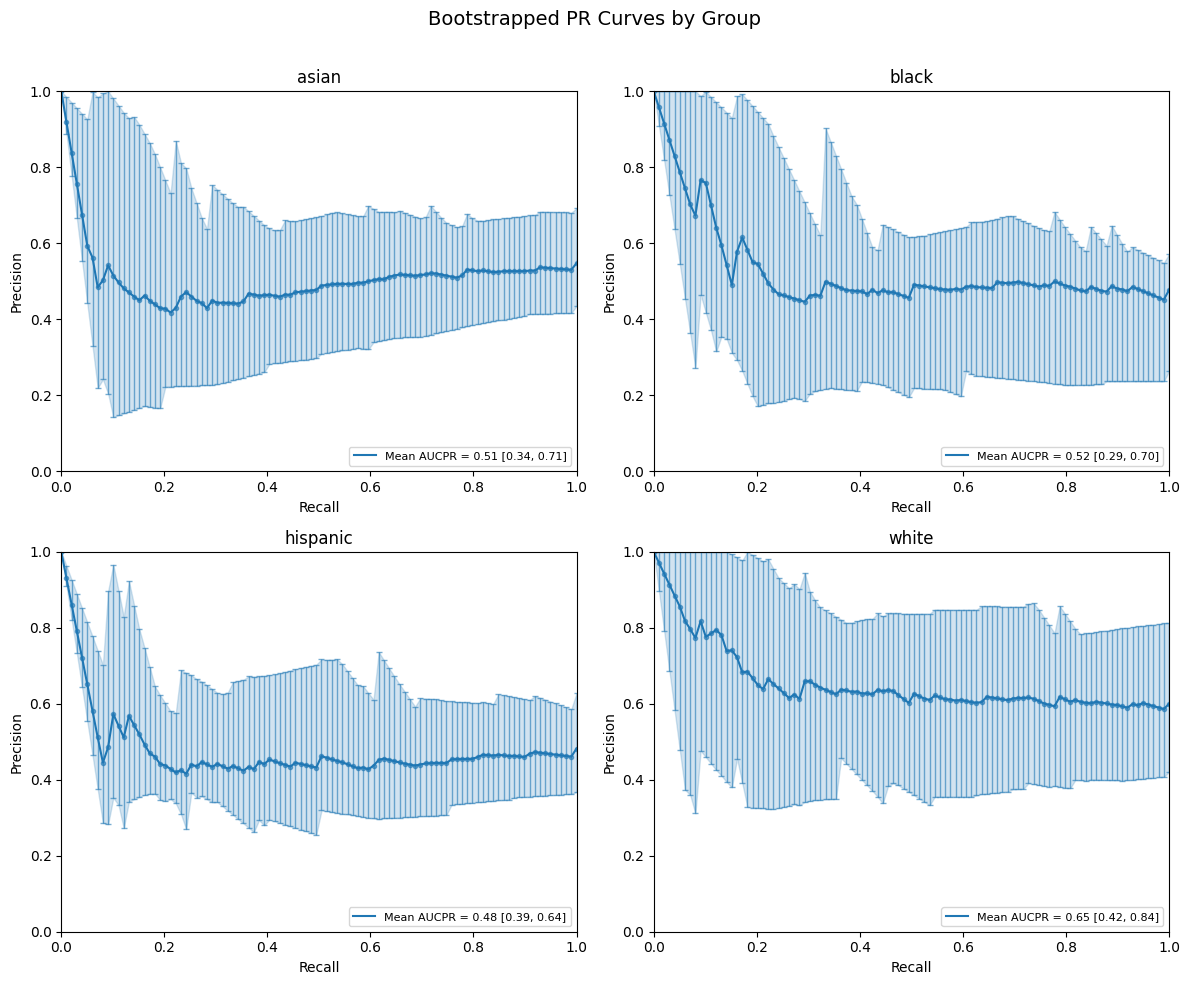

In [12]:
plot = eqb.eq_plot_bootstrapped_pr_curves(
    sliced,
    bar_every=100,
    save_path="./images",
)

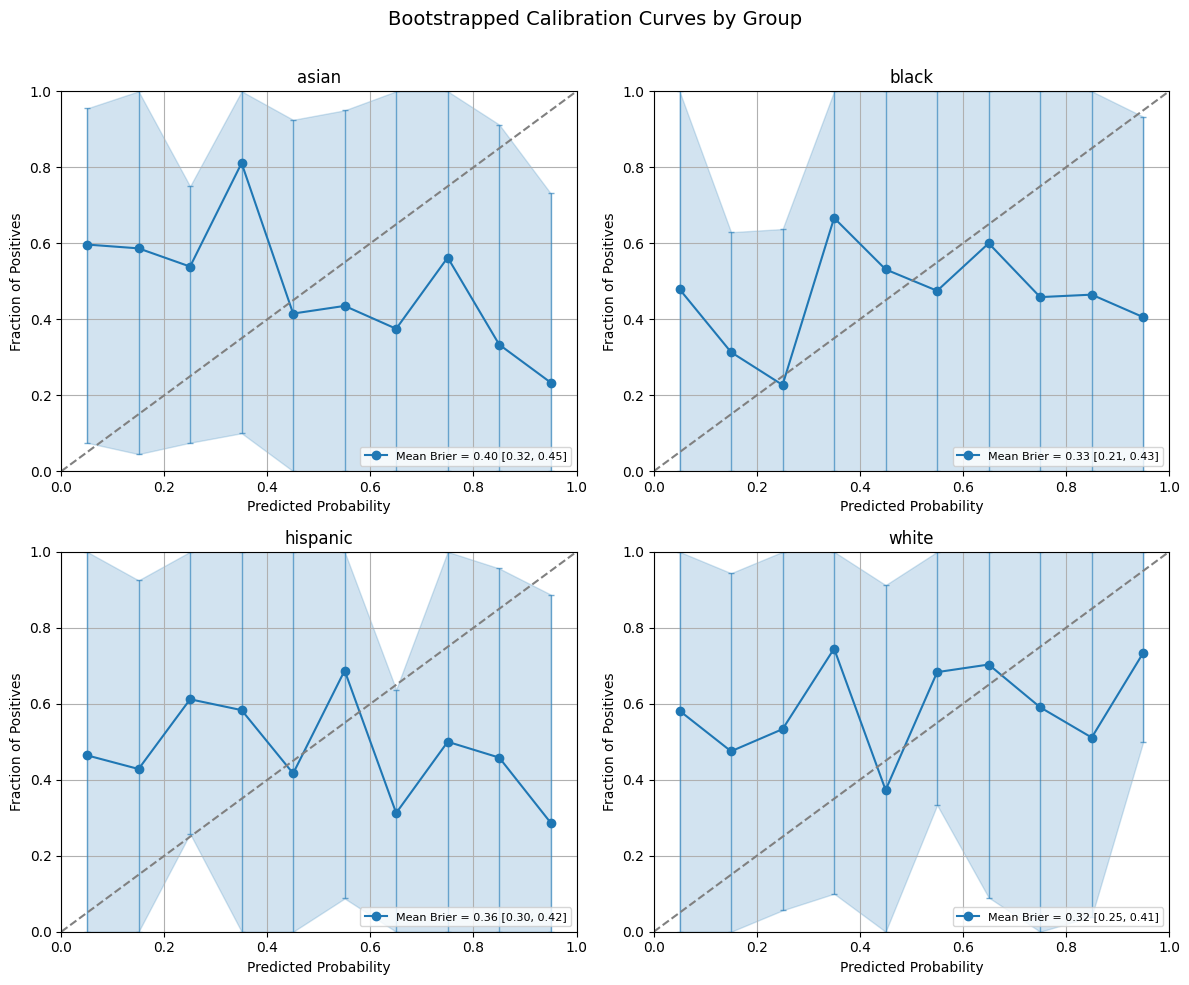

In [13]:
eqb.eq_plot_bootstrapped_calibration_curves(
    sliced,
    save_path="./images",
)